In [11]:
#default_exp ocr_inference

In [1]:
#export
from ocr.core import load_inference, plot
from fastai import *
from fastai.vision import *
import numpy as np
import cv2

### Example

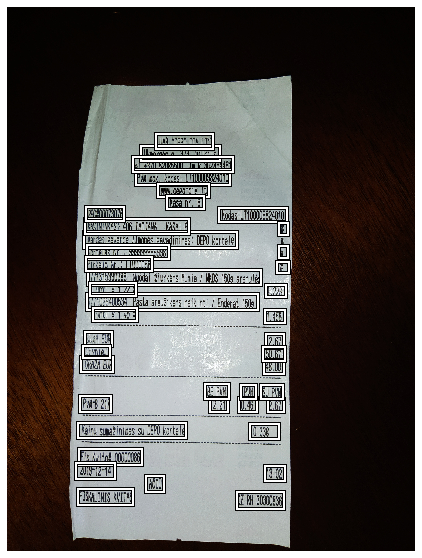

In [38]:
from ocr.bbox_east_training import *
from ocr.bbox_east_inference import TextBBoxPredictor, show_bboxes_on_image

im = cv2.imread('../test_data/cekis.jpg')
im = im[ :, :, [2,1,0] ] # BGR -> RGB

t = TextBBoxPredictor(model_name='east_bbox_10x3', use_gpu=False)
bboxes = t.image2bboxes(tensor(im), offset=10, nms_threshold=0.2)
show_bboxes_on_image(im, bboxes)

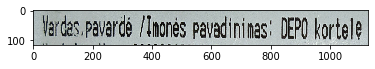

In [39]:
for t,l,b,r in bboxes:
    text_im = im[ t:b , l:r ]
    plot(text_im)
    break

In [4]:
#export
class OcrPredictor:
    def __init__(self):
        pass
    
    def image2text(self, image):
        pass

## CRNN

In [40]:
#export
def decode_ctc(texts, classes):
    """ convert text-index into text-label.
    @param: list(arr[N],...) :list of arrays of size N, where N can differ between elements (elements in arr are indexes)
    @return list(arr[M],...) :same just as strings and M are always <= N
    """
    out = []
    index = 0
    for t in texts:
        char_list = []
        for i in range(len(t)):
            if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank.
                char_list.append(t[i])
        out.append(tensor(char_list))
    return out

In [45]:
#export
from ocr.ocr_crnn_training import *

class CrnnOcrPredictor(OcrPredictor):
    def __init__(self, model_name='crnn_ocr', use_gpu=False):
        '''
        @param: str  :name of model in ../models dir
        @param: bool :use gpu? (model ~600mb)
        '''
        self.model_name, self.use_gpu = model_name, use_gpu
        if self.use_gpu: defaults.device = torch.device('cuda')
        else: defaults.device = torch.device('cpu')
        self.learner = load_inference(model_name)
        
    def image2text(self, image):
        '''
        @param: torch.arr[h,w,3] :(make sure its in RGB not BGR! and pixel range is [0-255])
        @return str              :text string
        '''
        image = Image(image.permute(2,0,1).float() / 255.)
        batch = self.learner.data.one_item(image)
        preds = self.learner.model.eval()(batch[0]).squeeze().argmax(-1)
        text = decode_ctc([preds], classes=self.learner.data.classes)[0]
        if list(text.shape) == []: return ''
        indexes = [int(i) for i in text]
        return ''.join([self.learner.data.classes[i] for i in indexes])

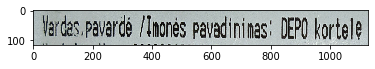

WARDAS PAVARDE /IMONES PAWADINIMAS: DEPO KORTELE


In [46]:
c = CrnnOcrPredictor(model_name='crnn_ocr', use_gpu=False)
plot(text_im)
text = c.image2text(tensor(text_im))
print(text)

## Tesseract

In [47]:
#export
import pytesseract

class TesseractOcrPredictor(OcrPredictor):
    def __init__(self):
        pass
        
    def image2text(self, image, config=("-l eng --oem 1 --psm 3")):
        '''
        @param: torch.arr[h,w,3] :(make sure its in RGB not BGR! and pixel range is [0-255])
        @param: str              :tesseract config w/ params
        @return str              :text string
        '''
        return pytesseract.image_to_string(to_np(image), config=config)

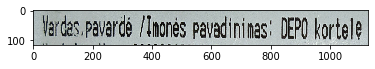

Varcas, pavarde /Tnonés pavadininas: DEPO kortele


In [48]:
c = TesseractOcrPredictor()
plot(text_im)
text = c.image2text(tensor(text_im))
print(text)

## Attention

In [49]:
#export
from ocr.ocr_attention_training import *

class AttentionOcrPredictor(CrnnOcrPredictor):
    def __init__(self, model_name='attention_ocr', use_gpu=False):
        super().__init__(model_name, use_gpu)

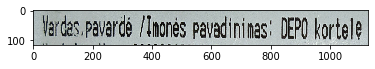

ARDES PAVARDE /INONES PEVADINIMAS: DEPD KORTELE


In [50]:
c = AttentionOcrPredictor(model_name='attention_ocr', use_gpu=False)
plot(text_im)
text = c.image2text(tensor(text_im))
print(text)

## Times

#### CRNN

In [15]:
%%timeit
p = CrnnOcrPredictor(use_gpu=False)
_ = p.image2text(tensor(text_im))

47.5 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit
p = CrnnOcrPredictor(use_gpu=True)
_ = p.image2text(tensor(text_im))

21.2 ms ± 51.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Tesseract

In [19]:
%%timeit
p = TesseractOcrPredictor()
_ = p.image2text(tensor(text_im))

242 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Attention

In [17]:
%%timeit
p = AttentionOcrPredictor(model_name='attention_ocr', use_gpu=False)
_ = p.image2text(tensor(text_im))

109 ms ± 557 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit
p = AttentionOcrPredictor(model_name='attention_ocr', use_gpu=True)
_ = p.image2text(tensor(text_im))

44.3 ms ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
